In [77]:
import os;
os.environ['KMP_DUPLICATE_LIB_OK']='True'; # for mac

In [78]:
import tensorflow as tf;
import numpy as np;
import json;
import matplotlib.pyplot as plt;
import pandas as pd;

In [79]:
print(tf.__version__);

2.1.0


In [80]:
class TensorProjectionLayer(tf.keras.layers.Layer):
    def __init__(self, q1,q2,q3, regularization='None', rate=10**-3,**kwargs):
        self.q1 = int(q1);
        self.q2 = int(q2);
        self.q3 = int(q3);
        self.e1 = 10**-6;
        self.e2 = 10**-6;
        self.e3 = 10**-6;
        self.regularization = regularization;
        self.rate = rate; # regularization coefficient
        super(TensorProjectionLayer, self).__init__(**kwargs);
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.q1, self.q2, self.q3);
    
    def get_config(self):
        base_config = super(TensorProjectionLayer, self).get_config();
        base_config['q1'] = self.q1;
        base_config['q2'] = self.q2;
        base_config['q3'] = self.q3;
        base_config['regularization'] = self.regularization;
        base_config['rate'] = self.rate;
        #base_config['output_dim'] = (self.q1, self.q2, self.q3);
        return base_config;
    
    def build(self, input_shape):
        self.p1 = int(input_shape[1]);
        self.p2 = int(input_shape[2]);
        self.p3 = int(input_shape[3]);
        
        if(self.q1 < self.p1):
            self.W1 = self.add_weight("W1",shape=(self.p1, self.q1),initializer='normal', trainable=True);
        if(self.q2 < self.p2):
            self.W2 = self.add_weight("W2",shape=(self.p2, self.q2),initializer='normal', trainable=True);
        if(self.q3 < self.p3):
            self.W3 = self.add_weight("W3",shape=(self.p3, self.q3),initializer='normal', trainable=True);
            
        super(TensorProjectionLayer, self).build(input_shape);

    # suppose that T: n x t1 x t2 x t3
    # k=1,2,3
    def kmode_product(self, T, A, k):

        # number of the observations
        n  = tf.shape(T)[0];
        t1 = tf.shape(T)[1];
        t2 = tf.shape(T)[2];
        t3 = tf.shape(T)[3];
        uk = tf.shape(A)[0];
        
        # Compute the size of the output-tensor
        if k == 1:
            new_shape = [n, uk, t2, t3];
        elif k == 2:
            new_shape = [n, t1, uk, t3];
        elif k == 3:
            new_shape = [n, t1, t2, uk];
        
        # Compute T xk A
        A = tf.expand_dims(A, 0);
        An =  tf.tile(A, [n, 1, 1]);
        Tk = self.unfold(T,k);
        ATk = tf.linalg.matmul(An, Tk);
        TxkA = self.fold(ATk, k, new_shape);
        return TxkA;
    
    def fold(self, Tk, k, new_shape):
        
        # this is Tensorly-version
        
        a = new_shape;
        
        if k == 1:
            reshape_order =  [0,1,2,3];
            permute_order = [0,1,2,3];
        elif k ==2:
            reshape_order =  [0,2,1,3];
            permute_order = [0,2,1,3];
        elif k == 3:
            reshape_order =  [0,3,1,2];
            permute_order = [0,2,3,1];
        
        new_shape = [a[reshape_order[0]], a[reshape_order[1]], a[reshape_order[2]], a[reshape_order[3]]];
        
        T_ = tf.reshape(Tk, new_shape);
        T = tf.transpose(T_, perm=permute_order);
        return T;
  
    def unfold(self, T, k):
        n  =  tf.shape(T)[0];
        t1 = tf.shape(T)[1];
        t2 = tf.shape(T)[2];
        t3 = tf.shape(T)[3];
        
        if k == 1:
            new_shape = [n, t1,t2*t3];
            A = T;
        elif k ==2:
            new_shape = [n, t2,t3*t1];
            A = tf.transpose(T, perm=[0,2,1,3]);
        elif k ==3:
            new_shape = [n, t3,t1*t2];
            A = tf.transpose(T, perm=[0,3,1,2]);
        
        Tk = tf.reshape(A,new_shape);
        
        return Tk;

    def call(self, X):
        n = tf.shape(X)[0];
        
        if self.q1 < self.p1:
            Iq1 = tf.eye(self.q1);
            W1T = tf.transpose(self.W1, perm=[1,0]);
            M1 = tf.math.add(tf.linalg.matmul(W1T,self.W1), Iq1 * self.e1);
            sqrtM1 = tf.linalg.sqrtm(M1);
            G1 = tf.linalg.inv(sqrtM1);
            U1 = tf.linalg.matmul(self.W1, G1); # p1 x q1
            U1T = tf.transpose(U1, perm=[1,0]); # q1 x p1
        
        if self.q2 < self.p2:
            Iq2 = tf.eye(self.q2);
            W2T = tf.transpose(self.W2, perm=[1,0]);
            M2 = tf.math.add(tf.linalg.matmul(W2T,self.W2), Iq2 * self.e2);
            sqrtM2 = tf.linalg.sqrtm(M2);
            G2 = tf.linalg.inv(sqrtM2);
            U2 = tf.linalg.matmul(self.W2, G2); # p2 x q2
            U2T = tf.transpose(U2, perm=[1,0]); # q2 x p2
            
        if self.q3 < self.p3:
            Iq3 = tf.eye(self.q3);
            W3T = tf.transpose(self.W3, perm=[1,0]);
            M3 = tf.math.add(tf.linalg.matmul(W3T,self.W3), Iq3 * self.e3);
            sqrtM3 = tf.linalg.sqrtm(M3);
            G3 = tf.linalg.inv(sqrtM3);
            U3 = tf.linalg.matmul(self.W3, G3); # p3 x q3
            U3T = tf.transpose(U3, perm=[1,0]); # q3 x p3

    
        Z = X;
        
        if self.q1 < self.p1:
            Z = self.kmode_product(Z, U1T, 1);
        if self.q2 < self.p2:
            Z = self.kmode_product(Z, U2T, 2);
        if self.q3 < self.p3:
            Z = self.kmode_product(Z, U3T, 3);
            
        # This is necessary. But I don't know why...
        Z = tf.reshape(Z, [n,self.q1,self.q2,self.q3]);
        
        # compute reconstruction error
        if self.regularization == 'reconstruction_error':
            X_ = Z;
            if self.q1 < self.p1:
                X_ = self.kmode_product(X_, U1, 1);
            if self.q2 < self.p2:
                X_ = self.kmode_product(X_, U2, 2);
            if self.q3 < self.p3:
                X_ = self.kmode_product(X_, U3, 3);
            #X_ = tf.reshape(X_, [n,self.p1, self.p2, self.p3]);
            dn2 = tf.math.squared_difference(X , X_); # n, p1,p2,p3
            dn2 = tf.math.reduce_mean(dn2,axis=1); # n, p2,p3
            dn2 = tf.math.reduce_mean(dn2,axis=1); # n, p3
            dn2 = tf.math.reduce_mean(dn2,axis=1); # n
            dn = tf.math.pow(dn2, 0.5);
            self.add_loss(self.rate *tf.math.reduce_mean(dn), True);
        elif self.regularization == 'total_variation':
            mz = tf.reduce_mean(Z, axis=0,keepdims = True);
            mz = tf.tile(mz,[n,1,1,1]);
            Z_ = Z - mz; # centerize
            v = tf.math.pow(Z_,2);
            v = tf.reduce_mean(v,axis=1);
            v = tf.reduce_mean(v,axis=1);
            v = tf.reduce_mean(v,axis=1);
            v = tf.math.pow(v,0.5);
            self.add_loss(self.rate *tf.math.reduce_mean(v), True);
            
        return Z;

In [81]:
batch_size = 100;
num_classes = 10;
epochs = 10;
# prepare data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data();

img_rows, img_cols = 28, 28

#
if tf.keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols);
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols);
    input_shape = (1, img_rows, img_cols);
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1);
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1);
    input_shape = (img_rows, img_cols, 1);

x_train = x_train.astype('float32');
x_test = x_test.astype('float32');
x_train /= 255;
x_test /= 255;
print(x_train.shape[0], 'train samples');
print(x_test.shape[0], 'test samples');
y_train = tf.keras.utils.to_categorical(y_train, num_classes);
y_test = tf.keras.utils.to_categorical(y_test, num_classes);

60000 train samples
10000 test samples


In [82]:
### TensorProjection Layer ###
model = tf.keras.Sequential();
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3),strides=1, padding='same',activation='relu', input_shape=input_shape));
model.add(tf.keras.layers.AveragePooling2D((2,2)));
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3),strides=1, padding='same',activation='relu'));
model.add(TensorProjectionLayer(9,9,16, regularization='total_variation', rate=1.0));
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(160, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(), metrics=[tf.keras.metrics.categorical_crossentropy,'accuracy'])
# fit
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test));
# compute score
score = model.evaluate(x_test, y_test, verbose=0);
print('Test loss:', score[0]);
print('Test accuracy:', score[1]);
# model save
model.save('model.h5');
# save history
temp = pd.DataFrame(history.history);
with open('history.json', 'w') as f:
    temp.to_json(f);


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 11s 178us/sample - loss: 0.2613 - categorical_crossentropy: 0.1818 - accuracy: 0.9478 - val_loss: 0.1284 - val_categorical_crossentropy: 0.0789 - val_accuracy: 0.9765
Epoch 2/10
60000/60000 [==============================] - 7s 119us/sample - loss: 0.0991 - categorical_crossentropy: 0.0586 - accuracy: 0.9831 - val_loss: 0.0767 - val_categorical_crossentropy: 0.0445 - val_accuracy: 0.9884
Epoch 3/10
60000/60000 [==============================] - 7s 119us/sample - loss: 0.0723 - categorical_crossentropy: 0.0432 - accuracy: 0.9872 - val_loss: 0.0605 - val_categorical_crossentropy: 0.0342 - val_accuracy: 0.9893
Epoch 4/10
60000/60000 [==============================] - 7s 119us/sample - loss: 0.0588 - categorical_crossentropy: 0.0349 - accuracy: 0.9898 - val_loss: 0.0532 - val_categorical_crossentropy: 0.0311 - val_accuracy: 0.9896
Epoch 5/10
60000/60000 [=============================

In [83]:
#if we load from .h5
#model = tf.keras.models.load_model('model.h5', compile=True,custom_objects={'TensorProjectionLayer': TensorProjectionLayer});
history_json                 = pd.read_json('history.json');
accuracy                     = history_json['accuracy'];
val_accuracy                 = history_json['val_accuracy'];
loss                         = history_json['loss'];
val_loss                     = history_json['val_loss'];
categorical_crossentropy     = history_json['categorical_crossentropy'];
val_categorical_crossentropy = history_json['val_categorical_crossentropy'];

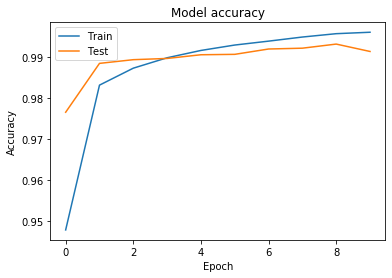

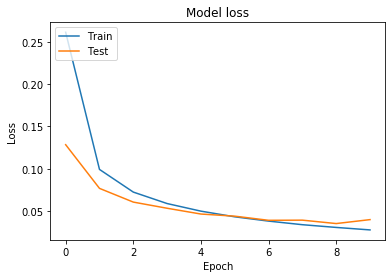

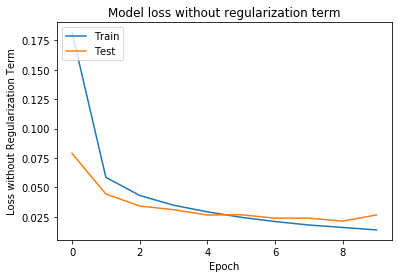

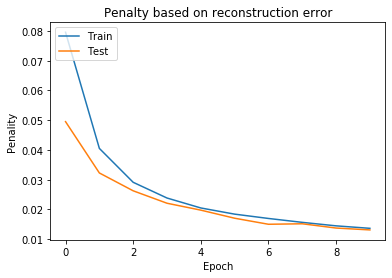

In [84]:
# Dir
os.makedirs('model-images', exist_ok=True);
# Plot training & validation accuracy values
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model-images/accuracy.png',dpi=160);
plt.show()

# Plot training & validation loss values
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model-images/loss.png',dpi=160);
plt.show()

# Plot training & validation loss without regularization term
plt.plot(categorical_crossentropy)
plt.plot(val_categorical_crossentropy)
plt.title('Model loss without regularization term')
plt.ylabel('Loss without Regularization Term')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model-images/loss-without-regularization.png',dpi=160);
plt.show()

# Plot reconstruction error
plt.plot(loss-categorical_crossentropy)
plt.plot(val_loss-val_categorical_crossentropy)
plt.title('Penalty based on reconstruction error')
plt.ylabel('Penality')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model-images/regularization.png',dpi=160);
plt.show()



In [85]:
####
#### Analysis of Robustness
####

In [86]:
#### We would like to visualize dL / dx which has a shape of 28x28 ####

In [87]:
#### Compute Gradients For testing images ####
x = tf.constant(x_test);
with tf.GradientTape() as g:
    g.watch(x);
    y = model.call(x);
    loss = tf.keras.losses.categorical_crossentropy(y_test, y);
model_dLdx_test = g.gradient(loss,x);

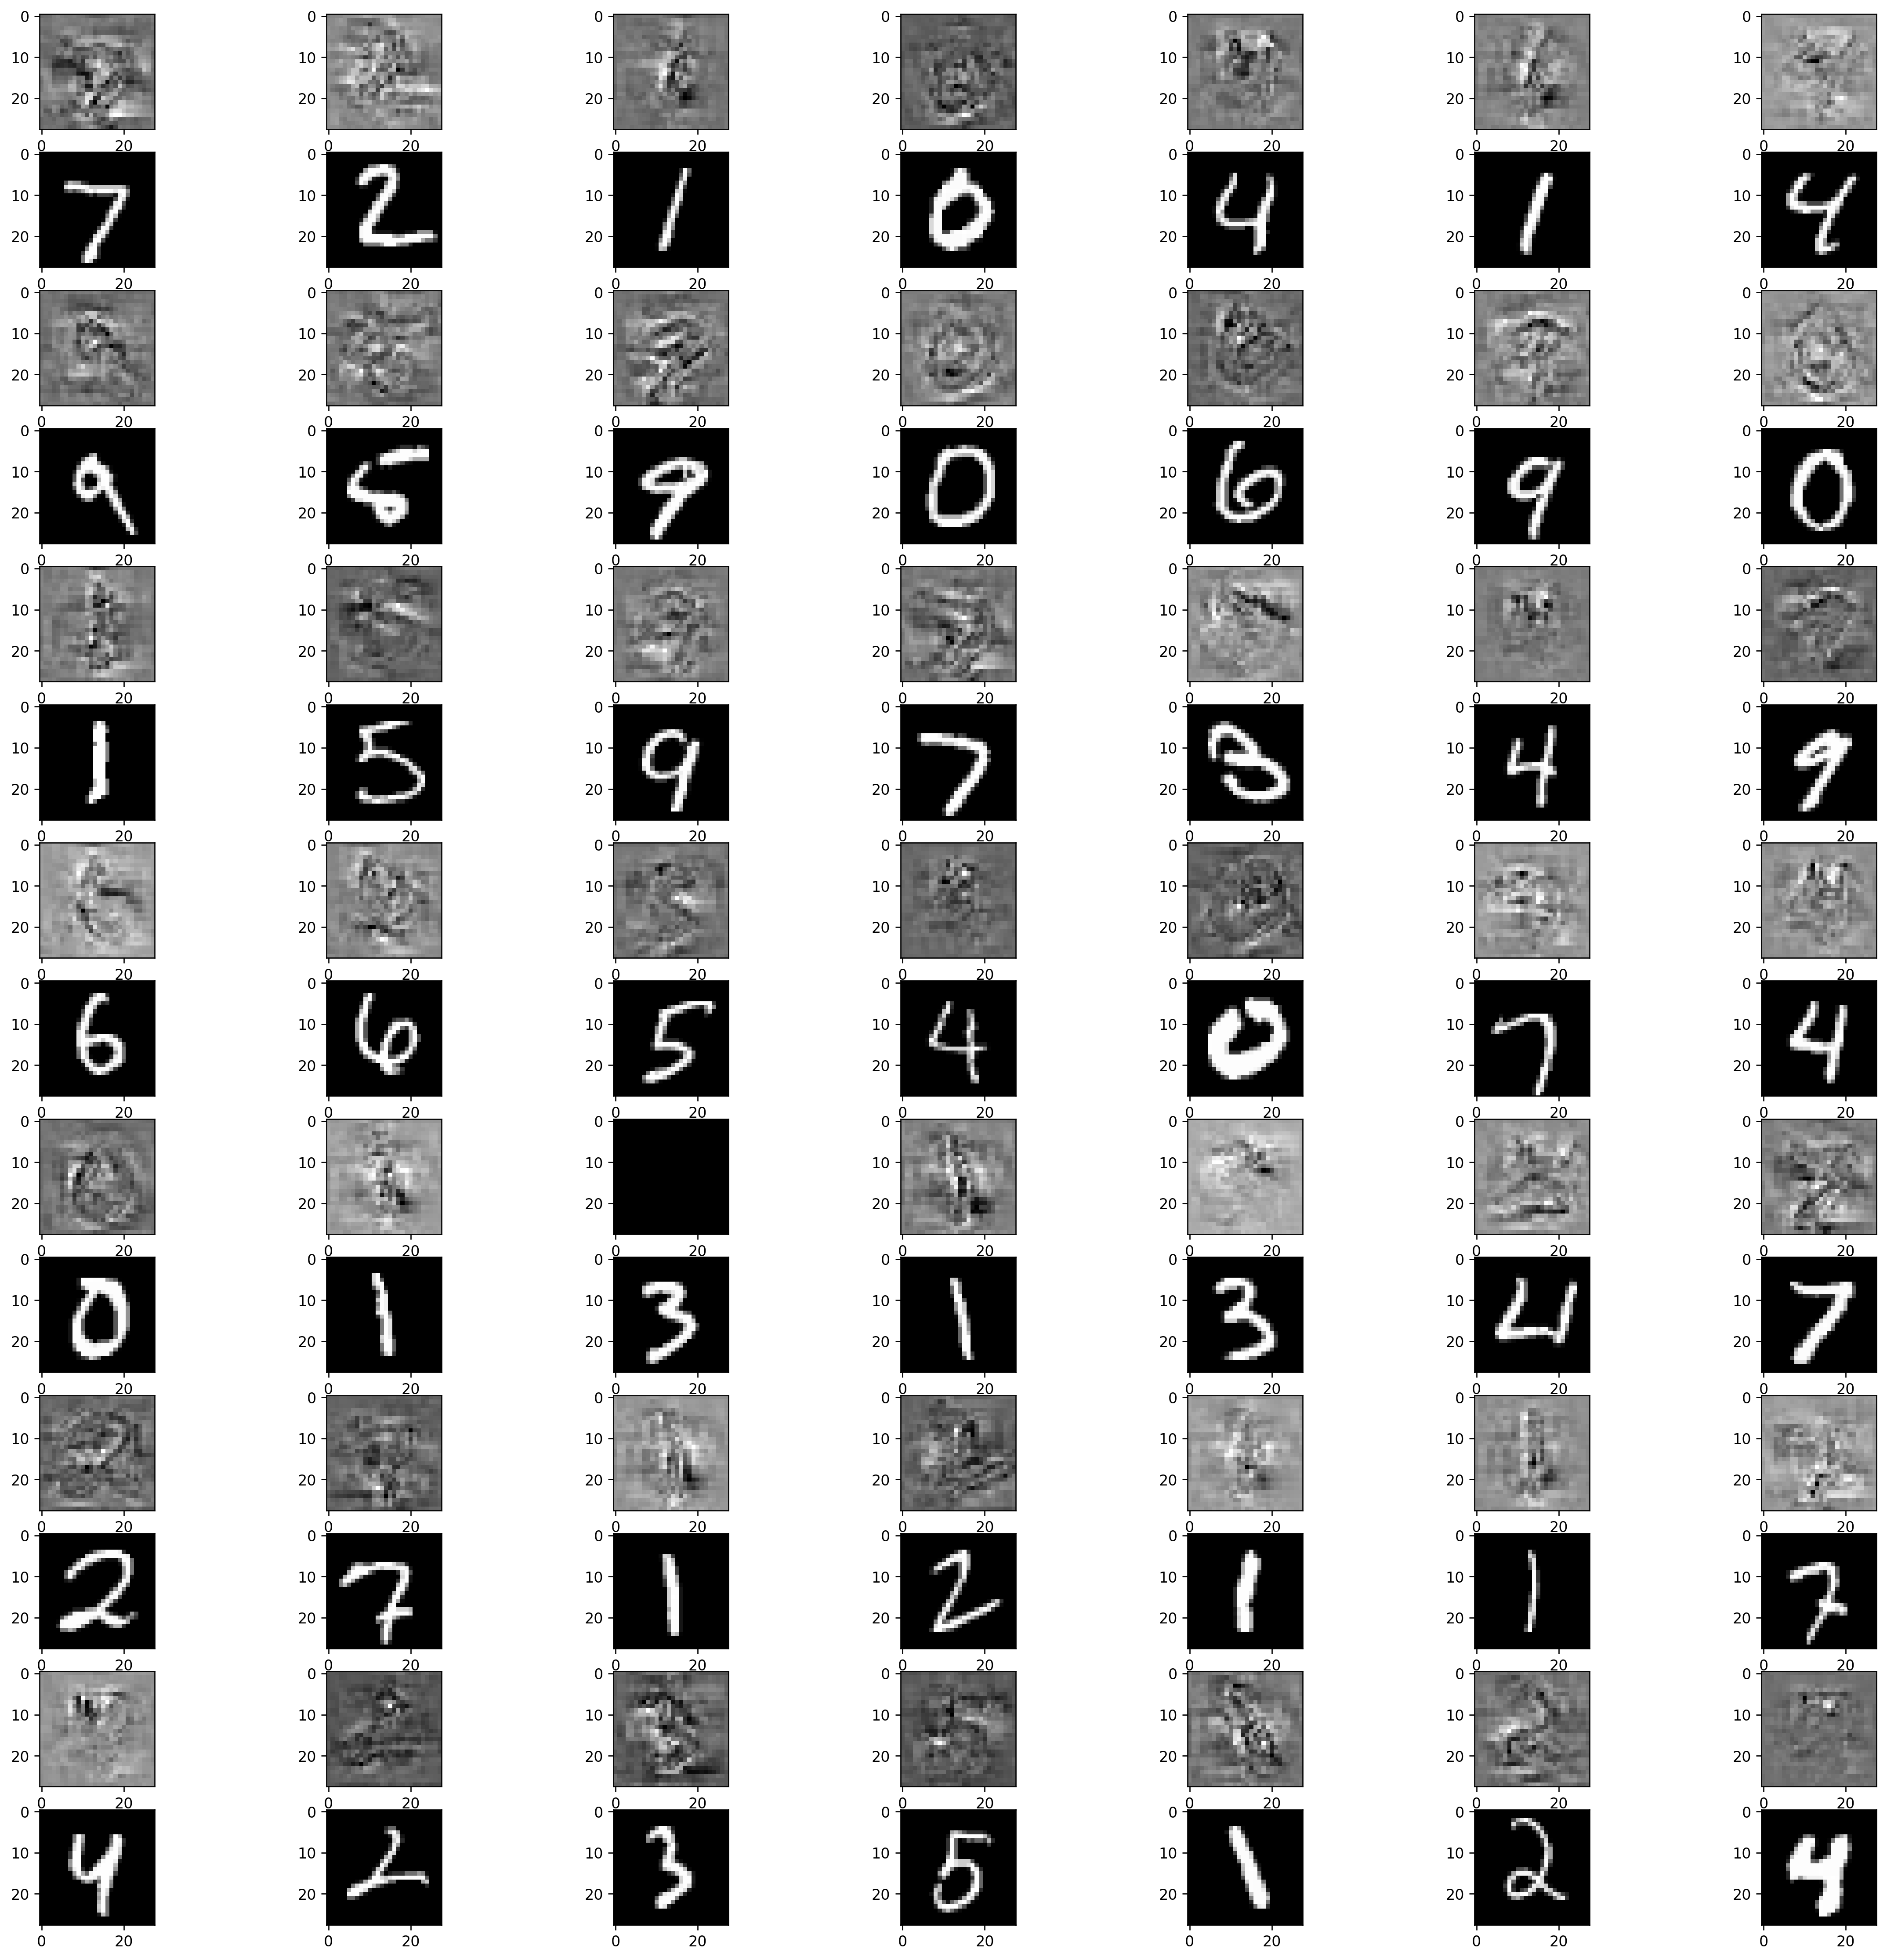

In [88]:
fig = plt.figure(figsize=(24,24),dpi=240);
fig.tight_layout();
I = 7;
J = 7;
for i in range(I):
    for j in range(J):
        m = i*J + j;
        p = i*J*2+j+1;
        ax=fig.add_subplot(I*2,J,p);
        ax.imshow(model_dLdx_test[m,:,:,0], cmap='gray');
        ax=fig.add_subplot(I*2,J,p+J);
        ax.imshow(x_test[m,:,:,0], cmap='gray');       
# save
# Dir
os.makedirs('model-images', exist_ok=True);
fig.savefig('model-images/dLdx_test.png');

In [89]:
#
#
# End
#
#
#

In [90]:
#
#
#
#
#
#
#

In [91]:
#### Alternative Version without regularization ####

In [92]:
#### No regularization
model2 = tf.keras.Sequential();
model2.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3),strides=1, padding='same',activation='relu', input_shape=input_shape));
model2.add(tf.keras.layers.AveragePooling2D((2,2)));
model2.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3),strides=1, padding='same',activation='relu'));
model2.add(TensorProjectionLayer(9, 9,16)); # without regulariation
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(160, activation='relu'))
model2.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model2.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(), metrics=[tf.keras.metrics.categorical_crossentropy,'accuracy'])
# fit
history2 = model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test));
score2 = model2.evaluate(x_test, y_test, verbose=0);
print('Test loss:', score2[0]);
print('Test accuracy:', score2[1]);
# model save
model2.save('model2.h5');
# save history
temp = pd.DataFrame(history2.history);
with open('history2.json', 'w') as f:
    temp.to_json(f);

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 166us/sample - loss: 0.1994 - categorical_crossentropy: 0.1994 - accuracy: 0.9400 - val_loss: 0.0608 - val_categorical_crossentropy: 0.0608 - val_accuracy: 0.9805
Epoch 2/10
60000/60000 [==============================] - 7s 114us/sample - loss: 0.0575 - categorical_crossentropy: 0.0575 - accuracy: 0.9823 - val_loss: 0.0402 - val_categorical_crossentropy: 0.0402 - val_accuracy: 0.9878
Epoch 3/10
60000/60000 [==============================] - 7s 114us/sample - loss: 0.0383 - categorical_crossentropy: 0.0383 - accuracy: 0.9884 - val_loss: 0.0352 - val_categorical_crossentropy: 0.0352 - val_accuracy: 0.9884
Epoch 4/10
60000/60000 [==============================] - 7s 114us/sample - loss: 0.0280 - categorical_crossentropy: 0.0280 - accuracy: 0.9911 - val_loss: 0.0318 - val_categorical_crossentropy: 0.0318 - val_accuracy: 0.9896
Epoch 5/10
60000/60000 [=============================

In [93]:
#if we load from .h5
#model2 = tf.keras.models.load_model('model2.h5', compile=True,custom_objects={'TensorProjectionLayer': TensorProjectionLayer});
history2_json                 = pd.read_json('history2.json');
accuracy2                     = history2_json['accuracy'];
val_accuracy2                 = history2_json['val_accuracy'];
loss2                         = history2_json['loss'];
val_loss2                     = history2_json['val_loss'];
categorical_crossentropy2     = history2_json['categorical_crossentropy'];
val_categorical_crossentropy2 = history2_json['val_categorical_crossentropy'];

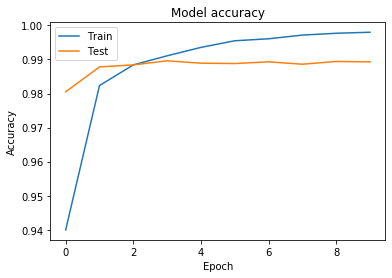

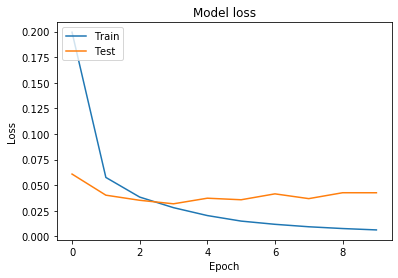

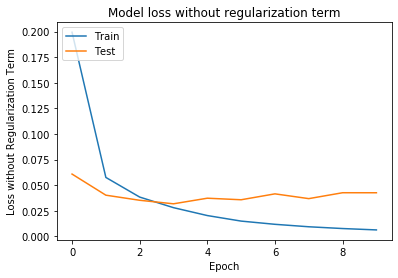

In [94]:
# Dir
os.makedirs('model2-images', exist_ok=True)
# Plot training & validation accuracy values
plt.plot(accuracy2)
plt.plot(val_accuracy2)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model2-images/accuracy.png',dpi=160);
plt.show()

# Plot training & validation loss values
plt.plot(loss2)
plt.plot(val_loss2)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model2-images/loss.png',dpi=160);
plt.show()

# Plot training & validation loss without regularization term
plt.plot(categorical_crossentropy2)
plt.plot(val_categorical_crossentropy2)
plt.title('Model loss without regularization term')
plt.ylabel('Loss without Regularization Term')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model2-images/loss-without-regularization.png',dpi=160);
plt.show()

# Plot reconstruction error
#plt.plot(loss2-categorical_crossentropy2)
#plt.plot(val_loss2-val_categorical_crossentropy2)
#plt.title('Penalty based on reconstruction error')
#plt.ylabel('Penality')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
#plt.savefig('model2-images/regularization.png',dpi=160);
#plt.show()

In [95]:
#### Compute Gradients For testing images ####
x = tf.constant(x_test);
with tf.GradientTape() as g:
    g.watch(x);
    y = model2.call(x);
    loss = tf.keras.losses.categorical_crossentropy(y_test, y);
model2_dLdx_test = g.gradient(loss,x);

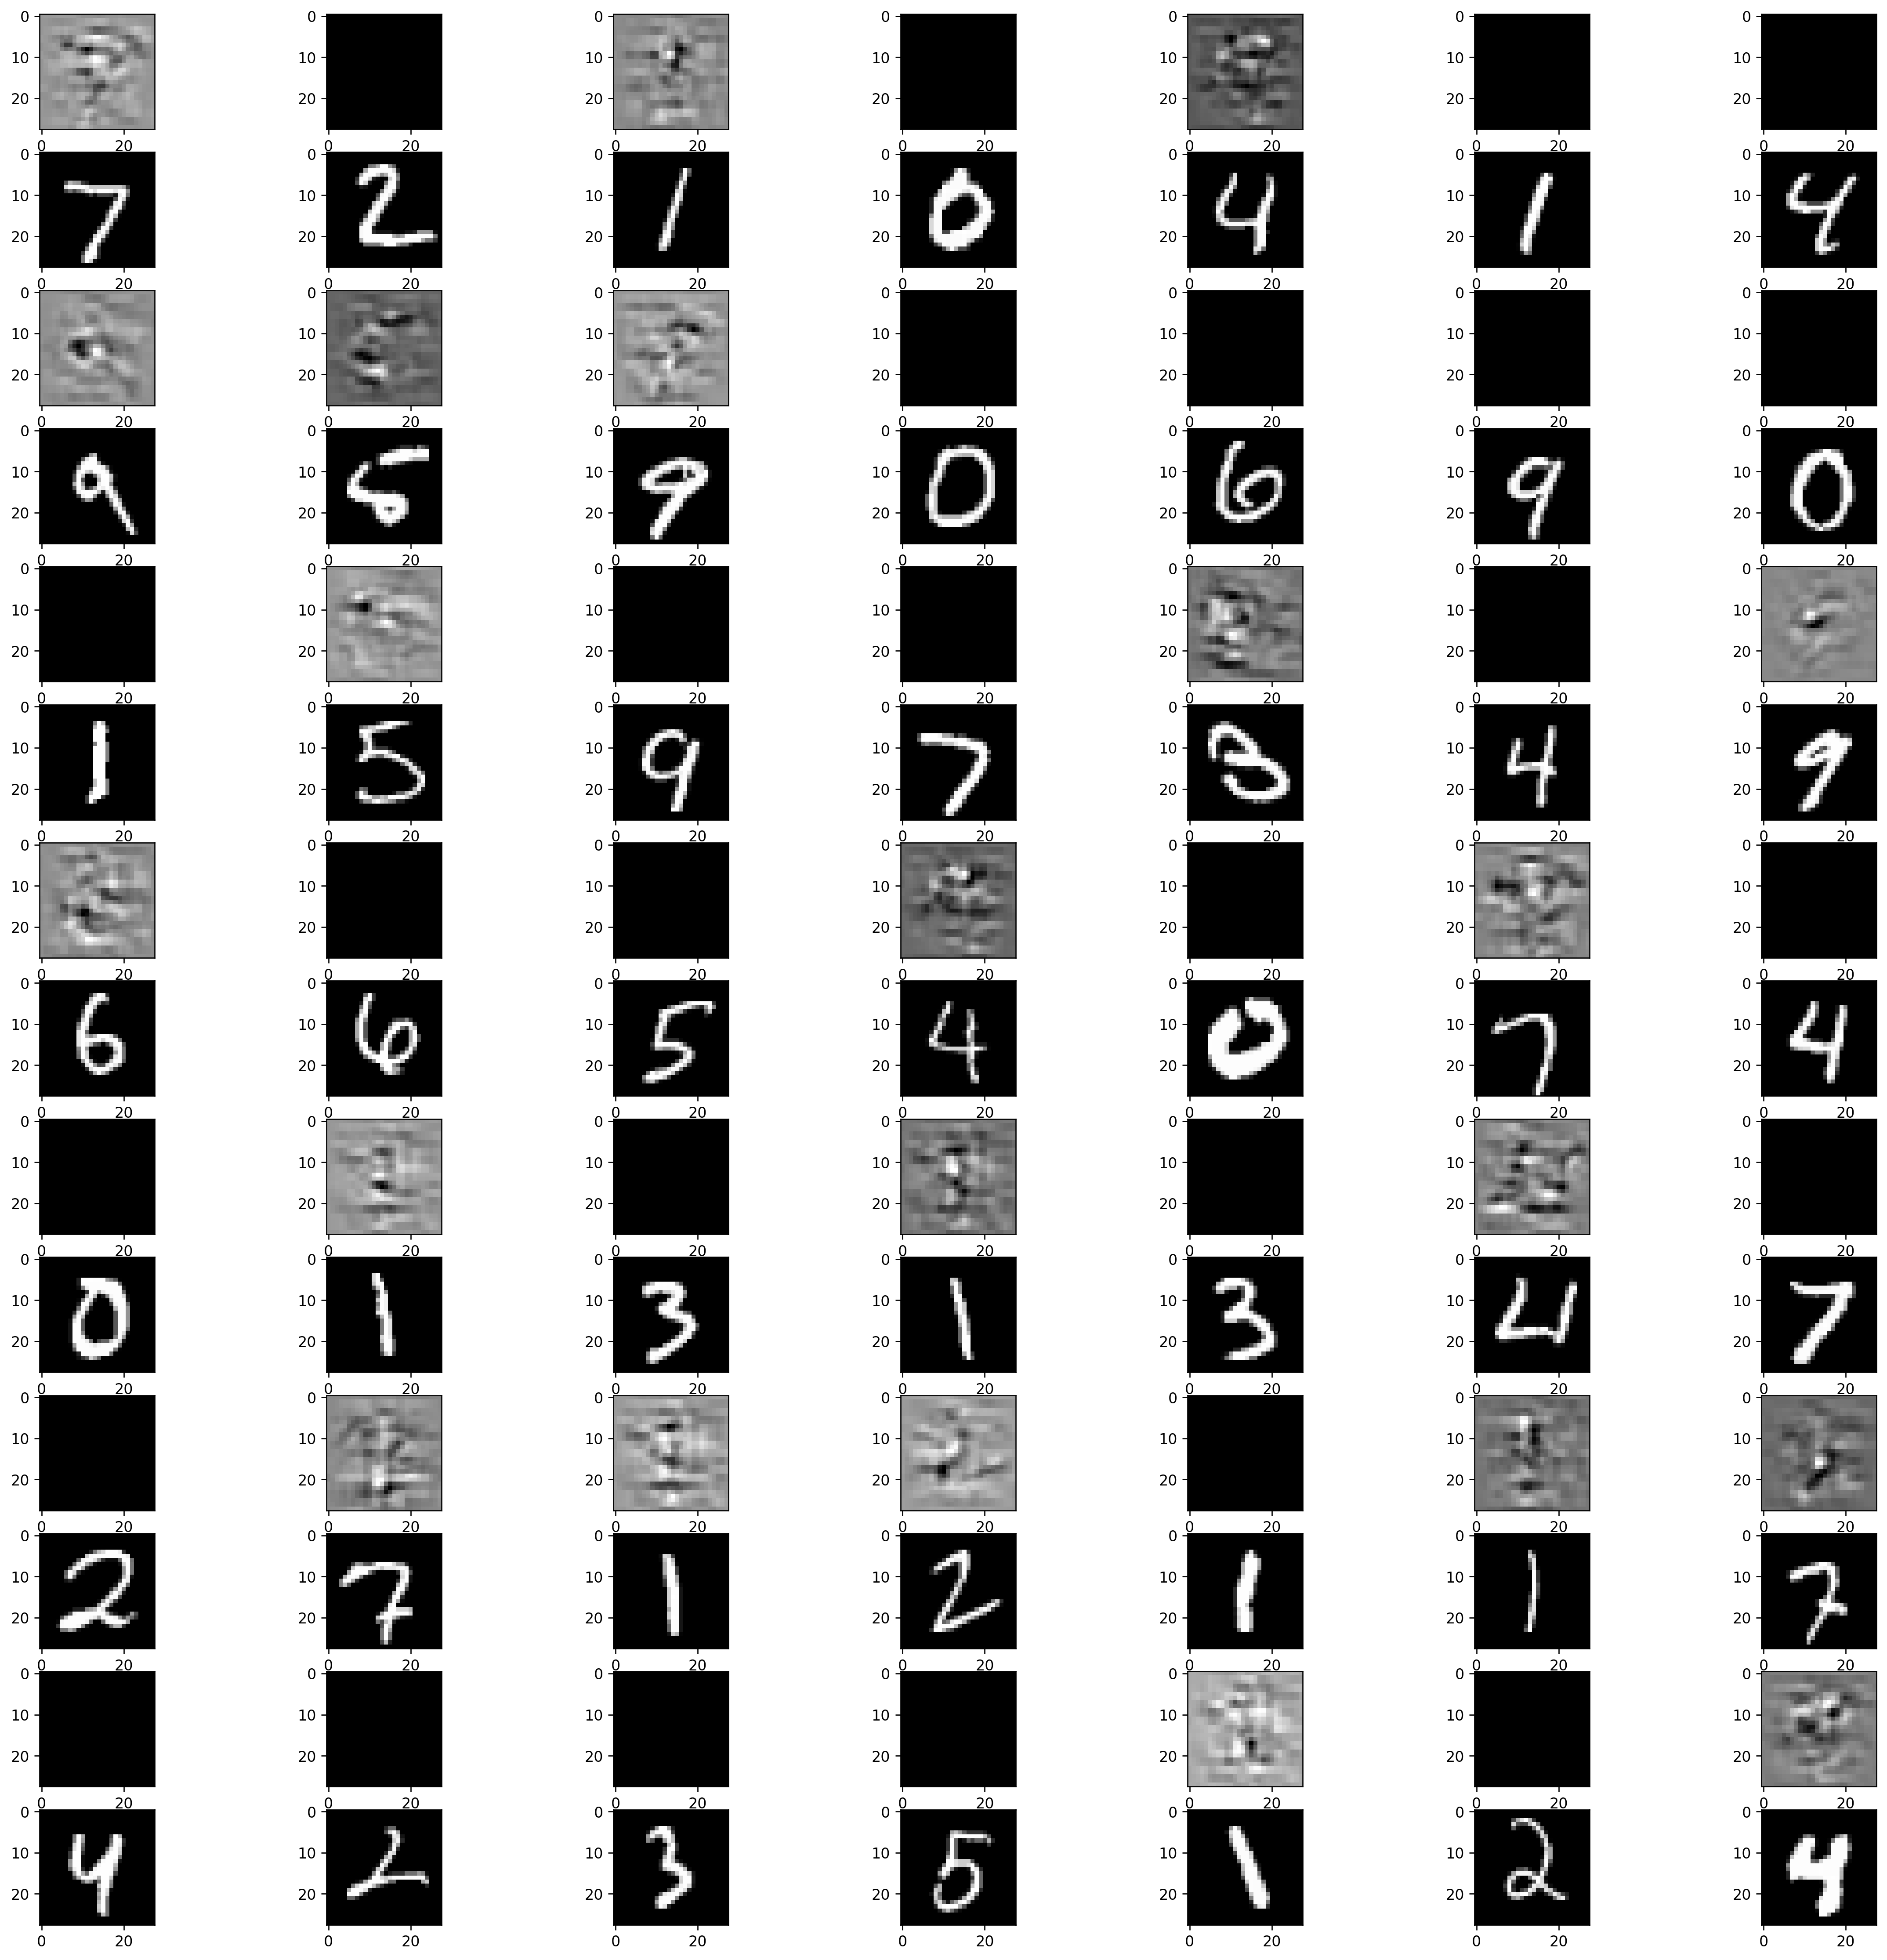

In [96]:
# show
fig = plt.figure(figsize=(24,24),dpi=240);
fig.tight_layout();
I = 7;
J = 7;
for i in range(I):
    for j in range(J):
        m = i*J + j;
        p = i*J*2+j+1;
        ax=fig.add_subplot(I*2,J,p);
        ax.imshow(model2_dLdx_test[m,:,:,0], cmap='gray');
        ax=fig.add_subplot(I*2,J,p+J);
        ax.imshow(x_test[m,:,:,0], cmap='gray');
# save
os.makedirs('model2-images', exist_ok=True);
fig.savefig('model2-images/dLdx_test.png');

In [97]:
#
#
#
# End
#
#
#

In [98]:
#
#
#
#
#
#

In [99]:
#
#
# classical CNN model
#
#
model3 = tf.keras.Sequential();
model3.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3),strides=1, padding='same',activation='relu', input_shape=input_shape));
model3.add(tf.keras.layers.AveragePooling2D((2,2)));
model3.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3),strides=1, padding='same',activation='relu'));
model3.add(tf.keras.layers.AveragePooling2D((2,2)));
model3.add(tf.keras.layers.Flatten())
model3.add(tf.keras.layers.Dense(160, activation='relu'))
model3.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
model3.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.RMSprop(), metrics=[tf.keras.metrics.categorical_crossentropy,'accuracy'])
# fit
history3 = model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test));
# compute score
score3 = model3.evaluate(x_test, y_test, verbose=0);
print('Test loss:', score3[0]);
print('Test accuracy:', score3[1]);
# model save
model3.save('model3.h5');
# save history
temp = pd.DataFrame(history3.history);
with open('history3.json', 'w') as f:
    temp.to_json(f);

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2652 - categorical_crossentropy: 0.2652 - accuracy: 0.9184 - val_loss: 0.0854 - val_categorical_crossentropy: 0.0854 - val_accuracy: 0.9736
Epoch 2/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0757 - categorical_crossentropy: 0.0757 - accuracy: 0.9767 - val_loss: 0.0518 - val_categorical_crossentropy: 0.0518 - val_accuracy: 0.9838
Epoch 3/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0518 - categorical_crossentropy: 0.0518 - accuracy: 0.9845 - val_loss: 0.0383 - val_categorical_crossentropy: 0.0383 - val_accuracy: 0.9871
Epoch 4/10
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0390 - categorical_crossentropy: 0.0390 - accuracy: 0.9878 - val_loss: 0.0370 - val_categorical_crossentropy: 0.0370 - val_accuracy: 0.9874
Epoch 5/10
60000/60000 [==============================] - 

In [100]:
#if we load from .h5
#model3 = tf.keras.models.load_model('model3.h5', compile=True,custom_objects={'TensorProjectionLayer': TensorProjectionLayer});
history3_json                 = pd.read_json('history3.json');
accuracy3                     = history3_json['accuracy'];
val_accuracy3                 = history3_json['val_accuracy'];
loss3                         = history3_json['loss'];
val_loss3                     = history3_json['val_loss'];
categorical_crossentropy3     = history3_json['categorical_crossentropy'];
val_categorical_crossentropy3 = history3_json['val_categorical_crossentropy'];

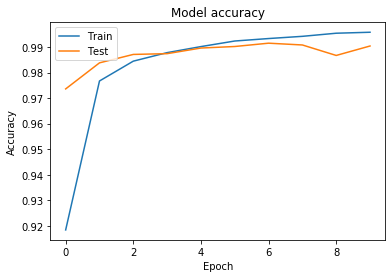

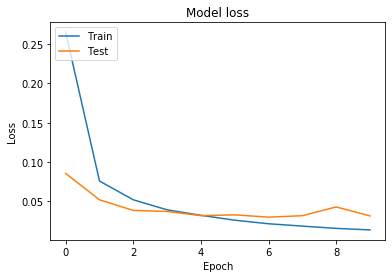

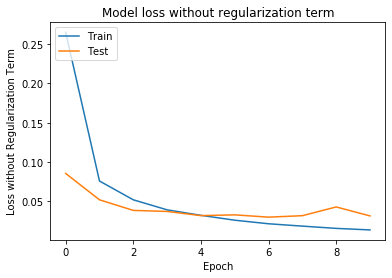

In [101]:
# Dir
os.makedirs('model3-images', exist_ok=True);
# Plot training & validation accuracy values
plt.plot(accuracy3)
plt.plot(val_accuracy3)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model3-images/accuracy.png',dpi=160);
plt.show()

# Plot training & validation loss values
plt.plot(loss3)
plt.plot(val_loss3)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model3-images/loss.png',dpi=160);
plt.show()

# Plot training & validation loss without regularization term
plt.plot(categorical_crossentropy3)
plt.plot(val_categorical_crossentropy3)
plt.title('Model loss without regularization term')
plt.ylabel('Loss without Regularization Term')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model3-images/loss-without-regularization.png',dpi=160);
plt.show()

# Plot reconstruction error
#plt.plot(loss2-categorical_crossentropy2)
#plt.plot(val_loss2-val_categorical_crossentropy2)
#plt.title('Penalty based on reconstruction error')
#plt.ylabel('Penality')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
#plt.savefig('model2-images/regularization.png',dpi=160);
#plt.show()

In [102]:
#### Compute Gradients For testing images ####
x = tf.constant(x_test);
with tf.GradientTape() as g:
    g.watch(x);
    y = model3.call(x);
    loss = tf.keras.losses.categorical_crossentropy(y_test, y);
model3_dLdx_test = g.gradient(loss,x);

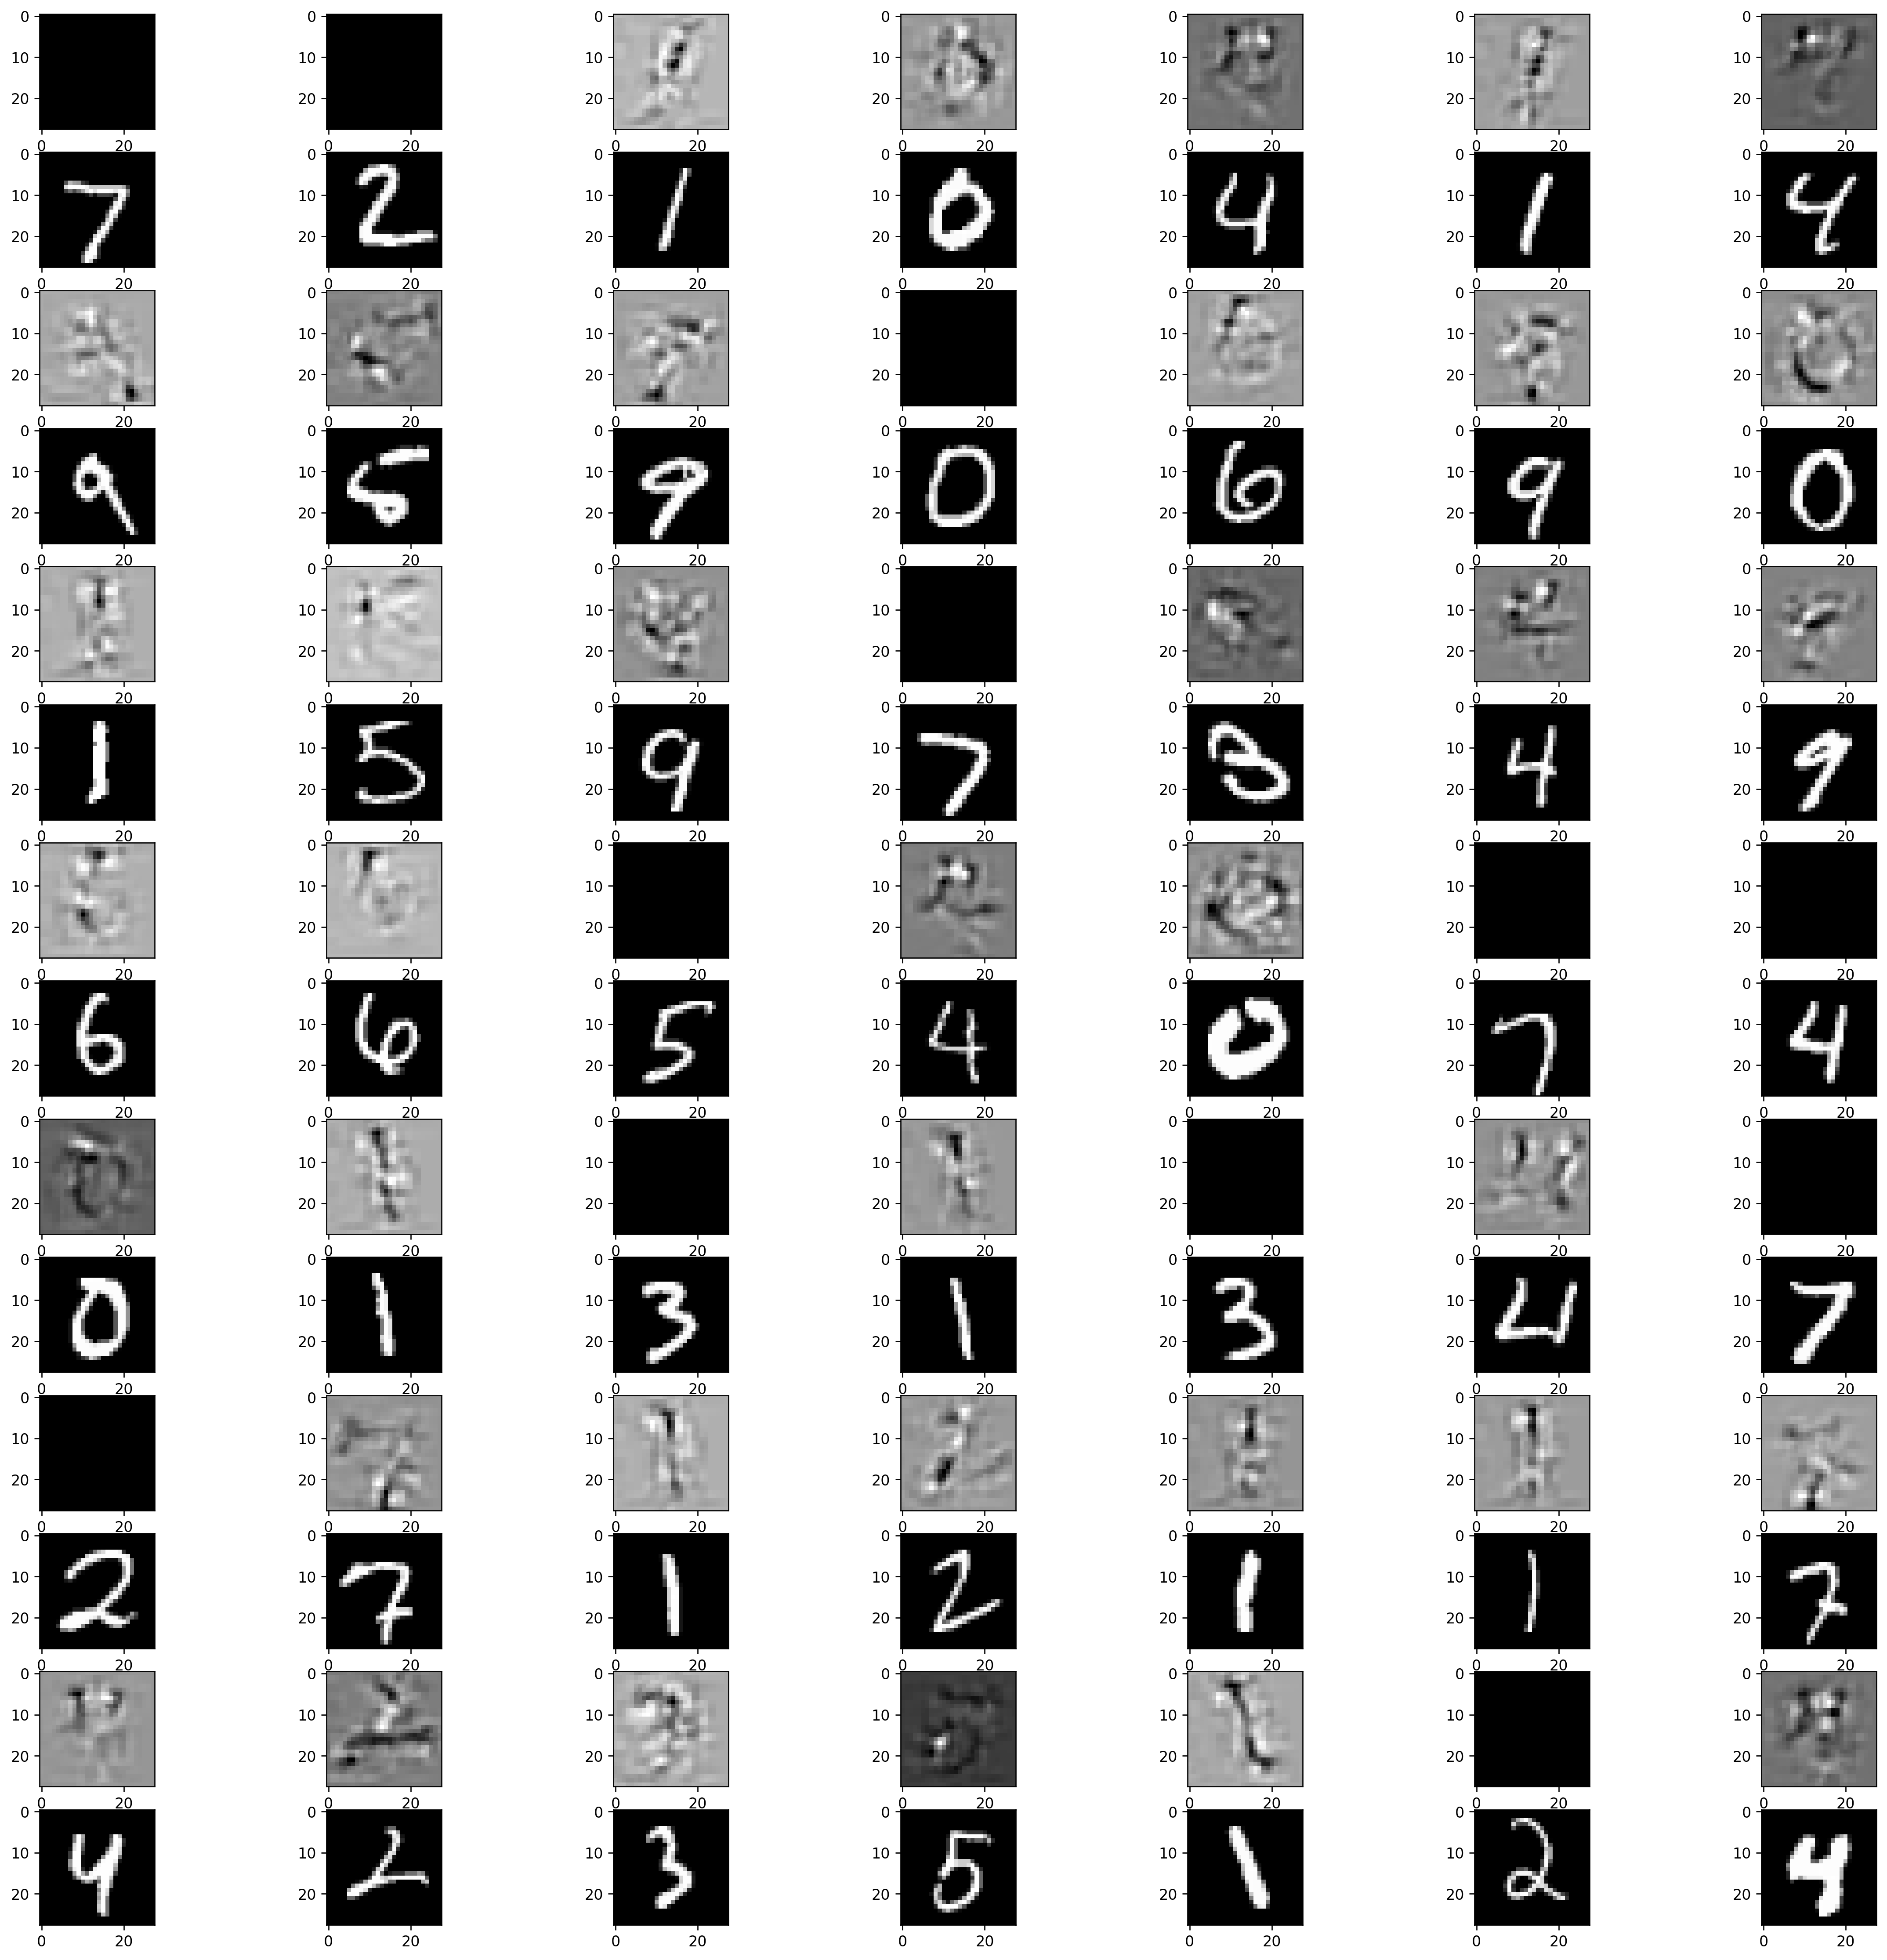

In [103]:
# show
fig = plt.figure(figsize=(24,24),dpi=240);
fig.tight_layout();
I = 7;
J = 7;
for i in range(I):
    for j in range(J):
        m = i*J + j;
        p = i*J*2+j+1;
        ax=fig.add_subplot(I*2,J,p);
        ax.imshow(model3_dLdx_test[m,:,:,0], cmap='gray');
        ax=fig.add_subplot(I*2,J,p+J);
        ax.imshow(x_test[m,:,:,0], cmap='gray');
os.makedirs('model3-images', exist_ok=True);
fig.savefig('model3-images/dLdx_test.png');